# Chapter 5 - Compressing Data via Dimensionality Reduction
차원축소를 이용한 데이터 압축

https://deeplearning4j.org/kr/eigenvector

## 1 비지도적 차원축소
PCA(Principal component analysis) : 주성분 분석을 활용

<img src="http://4.bp.blogspot.com/-pleL0HvLUgU/UYqpNFdd8EI/AAAAAAAAAHA/uf11u9lcq5g/s1600/PCA_1.png" align="left">

In [1]:
# 주성분 분석 : '최대분산' 방향으로, 새로운 공간에 '더 작은 차원'으로 투영
# 1. 설명적 데이터 분석
# 2. 주식시장 거래의 잡음신호 처리
# 3. 유전데이터 표현수준

### 주성분 분석
산포도를 가장 길게 퍼져있는 방향 축 하나와,

이들 방향 축 중 '분산'값이 가장 큰 축 (2차원 : 2개축,  3차원 : 3개의 축)

<img src="https://deeplearning4j.org/img/scatterplot_line.png" align='left'>

In [2]:
# 분산분리 process.
# 1 d 차원 데이터를 표준화 (Standarized) 한다
# 2 공분산 행렬을 만들어, eigen_vector(고유벡터) 와 eigen_value(고유값)로 분리
# 3 가장 큰 'k' eigen_value(고유값) 에 대한 eigne_vector(고유벡터) 를 선택한다
# 4 맨 위의 'k' eigen_vector(고유벡터) 로부터 '투영행렬' W 를 만든다
# 5 새로운 feature 부분공간을 얻기위해 'W'를 사용하여, X를 변환한다

#### eigen_vector : 고유 방향 (선형변환시)
고유벡터(파란 화살표) : 차원이 변해도, 벡터가 변하지 않음 (행렬과 투영벡터의 방향이 일치)

떄문에 방향은 같고, scala 만 바뀐다 (내적곱만 하면 된다)

결과 : 행렬의 대표적 vector (힘의 방향) 추출 (가장 분산이 큰 방향벡터를 추출한다)

<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Eigenvectors.gif" align='left'>

#### eigen_value : 고유 값
고유벡터(파란 화살표)의 '상관계수'로써

고유벡터가 여럿일 떄 각 축의 공분산 값으로써, 

결과적으로 고유벡터 수 만큼의 '공분산 행렬'로 출력된다 (2x2 공분산 행렬 결과값 예시)

<img src="https://deeplearning4j.org/img/covariances.png" align='left'>

### 공분산
X 와 Y 가 연관이 없을 떄 : 

공분산(두 변수축의 대각선으로써, 두 변수가 연관되어 같이 변하는 정도를 계산한 값//데이터 분포형태)은 '0'이 된다.

1. 공분산행렬 : 데이터 분포형태를 나타낸다
2. 상관계수 : 공분산을 -1 ~ 1 의 값으로 정규화(Normalized)한 값

### 01 Import Data
Wine 데이터 불러오기/ 70,30 나누기/ 표준화

In [3]:
import pandas as pd

df_wine = pd.read_csv('./data/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# 훈련 데이터 70%, test 데이터 30%
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
# PCA 적용전, 데이터를 표준화 (Standarized)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### 02 공분산 행렬을 만들고, 공분산 쌍을 지정한다
두 feature간 '공분산'을 쌍으로 계산 - 평균은 0이 된다. 
  1. '+' : feature 가 같은 방향으로 증감
  2. '-' : feature 기 다른 방향으로 증감

In [6]:
# 공분산행렬의 eigne_vector 는 PCA(주성분 분석) 을 나타내는 반면
# eigne_value의 대응값은 그들의 '규모'를 정의할 수 있다

In [7]:
# 공분산 행렬과, 공분산 행렬의 eigen_pair
import numpy as np
cov_mat = np.cov(X_train_std.T)  # np.cov() : 공분산 행렬을 계산
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # np.linalg() : 공분산 행렬의 eigne_pair(고유값 분해)를 계산
print(cov_mat.shape, '\n\nEigenvalues  length : {}\n{}'.format(len(eigen_vals), eigen_vals ))

(13, 13) 

Eigenvalues  length : 13
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [8]:
# eigne_value : eigne_vector 의 크기를 정의하며, 내림차순으로 정렬
# 13개의 고유값을 비교하기 위해 '설명분산비율' 을 ploting 한다 (설명분산값의 누적합을 계산) 
# 설명분산비율 : 고유값 총합에 대한 개별 고유값의 비율
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

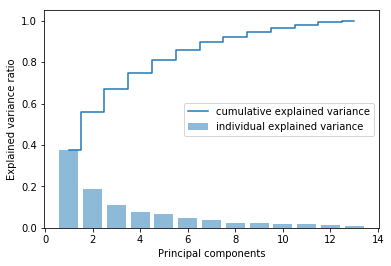

In [9]:
# 설명분산의 누적합을 시각화
import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')    # 개별 eigen_value 내림차순 정렬
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')   # 누적 합
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components'); plt.legend(loc='best'); plt.show()

In [10]:
# 분석결과
# 첫 feacture 가 전체분산의 40%를 차지
# 1,2 feature 합이 전체의 60%를 차지

### 03 feature 의 변환
eigen_value를 내림차순으로 eigen_pair 정렬후

선택한 eigen_vector 로 부터 '투영행렬'을 만든 뒤

'투영행렬'을 사용해서 'low dimention 부분공간'으로 변환

In [11]:
# eigen_pairs 를 생성 : (eigen_value, eigen_vector) 의 튜플
# 참고 : LDA section 을 활용하는게 더 효과적이다 
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

eigen_pairs.sort(key=lambda k: k[0], reverse=True) # high to low 로 정렬
eigen_pairs[:3]

[(4.8923083032737438,
  array([ 0.14669811, -0.24224554, -0.02993442, -0.25519002,  0.12079772,
          0.38934455,  0.42326486, -0.30634956,  0.30572219, -0.09869191,
          0.30032535,  0.36821154,  0.29259713])),
 (2.4663503157592301,
  array([ 0.50417079,  0.24216889,  0.28698484, -0.06468718,  0.22995385,
          0.09363991,  0.01088622,  0.01870216,  0.03040352,  0.54527081,
         -0.27924322, -0.174365  ,  0.36315461])),
 (1.4280997275048457,
  array([-0.11723515,  0.14994658,  0.65639439,  0.58428234,  0.08226275,
          0.18080442,  0.14295933,  0.17223475,  0.1583621 , -0.14242171,
          0.09323872,  0.19607741, -0.09731711]))]

In [12]:
# 위에서 분석한 1, 2번쨰 데이터의 eigen_vector를 수집한다
# eigen_vector 는 '단위길이'가 1로 scaling 된다
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


In [13]:
# X_train_std[0].dot[w]

In [14]:
# 내적곱 계산을 활용해, 두 개의 주성분으로 변환
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

In [15]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

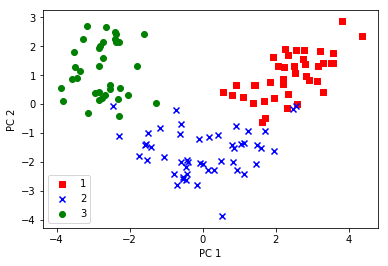

In [16]:
# matplotlib ploting
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left'); plt.show()

In [17]:
# 해석
# X 축은  첫번쨰 주성분을 기준, Y 축은  두번쨰 주성분을 지군으로 분포를 재배치
# Y 축 보다는, X 축을 기준으로 더 잘 분류가 된다.

### 04 scikit - learn 을 활용한 PCA 분석
위에서 만든 'X_train' 데이터에 PCA 모듈을 활용해 logistic 분석을 사용해 변환된 sample을 분류

In [18]:
# 앞장의 plot_decision_region 을 통해서 결정영역을 시각화
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max()); plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.6, c=cmap(idx),edgecolor='black',
                    marker=markers[idx],label=cl)

In [19]:
# scikit learn 에서 PCA 모듈 불러오기
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

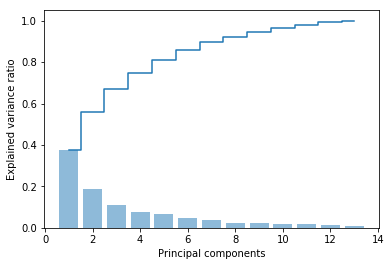

In [20]:
# 13개 feature 를 대상으로 PCA 분석
# pca.explained_variance_ratio_ 을 시각화 분석 
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components') ; plt.show()

In [21]:
# 상위 2개 feature 를 대상으로 PCA 분석
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

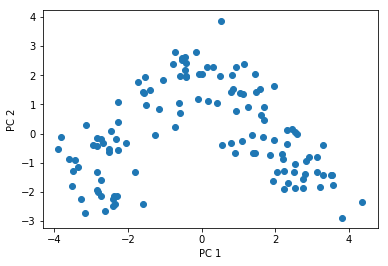

In [22]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2'); plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

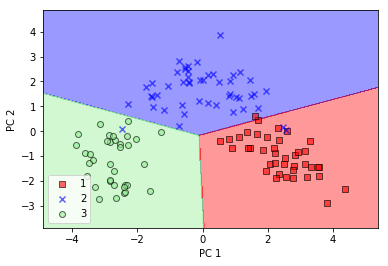

In [24]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend(loc='lower left'); plt.show()

In [25]:
# 위의 주성분 분석과 위/아래가 뒤바뀐 결과를 출력
# 이는 eigen_vector의 '-', '+' 부호에 따른 영향이다.

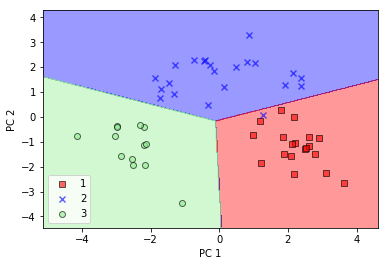

In [26]:
# 이를 확인하기 위해, X_test 에 logistic 회귀 결정영역을 plot
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend(loc='lower left'); plt.show()

In [27]:
# logistic 회귀분류 성능결과를 test
# logistic 3영역 분류 데이터 중 단1개만 오분류가 되고 나머지는 제대로 분류

In [28]:
# n_components=None : 주성분 설명분산 비율값을 확인 
# 모든 주성분은 유지되고, 설명 분산비율의 확인가능
# 차원 축소를 수행하는 대신, 정렬된 순수로 모든 주성분을 반환한다
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

## 2 지도적 데이터 압축
LDA(Linear Discriminant Analysis) : 선형판별분석을 활용

<img src="https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png" align='left' width='600'>

In [29]:
# PCA 는 데이터 내부 '최대 분산의 수직요소 축'을 통해서 차원을 축소
# LDA 는 분류 분리를 최적화 하는 feature 의 '부분공간'를 찾음이 목표
# 성능은 PCA가 더 효율적인 경우도 있으므로, 비교해 나가면서 적용 할 것

In [30]:
# LDA의 X 축은 '정규분산'을 갖는 '두 개의 분류'로 분리
# Y 축은 어떤 분류정보도 탐지하지 못해서 선형판별은 실패

# LDA의 전제 : 1. 데이터의 정규분포 성격을 갖는다
#            2. 분류들은 동일한  공분한 행렬을 갖는다
#            3. feature는 통계적 상호독립성을 갖는다.

In [31]:
# LDA 연산 process
# 1 d차원의 데이터를 표준화 한다 (d : feature 수)
# 2 각 분류의 'd차원 평균벡터'를 계산한다
# 3 '분류간' 이산행렬(Sb)과, '분류내' 이산행렬(Sw)을 계산
# 4 Sw-1 x Sb 의 eigen_vector 와 이에대한 eigne_value를 계산
# 5 d X k 차원의 '변환행렬' (W)를 만들기 위해, k개 eigen_value에 대한 k개의 eigen_vector를 선택한다. 

### 01 이산행렬을 계산
표준화 데이터를 바탕으로, '분류간 이산행렬'(Sb)과 '분류내 이산행렬'(Sw)을 계산

In [32]:
# 평균벡터를 연산한다
# 개별 분류(i) 샘플의 평균 feature 값으로 구성
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [33]:
# 평균벡터로, '분류내 이산행렬(Sw)' 을 계산
# Compute the within-class scatter matrix
d = 13                    # feature의 갯수를 지정
S_W = np.zeros((d, d))    # S_W (개별 분류내 이산행렬 크기의 zero matrix 만들기)

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))                   # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                               # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [34]:
# 이산행렬을 계산시 '분류 레이블이 균일하게 분포'됨을 가정
# 하지만 레이블을 출력 확인하면, 균일하지 않음이 확인가능
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [35]:
# 위의 분포가 다른 문제를 보완할 필요가 존재
# 이산행렬 Si을 분류샘플의 수(N)로 나누면, 공분산의 행렬과 같음을 확인가능
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [36]:
# 위 계산결과를 뷴류간 이산행렬로 계산 Sb
# mean_overall 은 전체의 평균으로 모든분류의 샘플을 포함한 결과를 계산

mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)          # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 02 새로운 feature 부분공간에 대한 선형 판별 선택
eigen_value를 내림차순으로 정렬

In [37]:
# 행렬 Sw-1 Sb 의 일반화된 eigen_value 문제를 해결
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# [ (eigenvalue, eigenvector) tuples 의 list ] 로 정리
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# [ (tuples) ] 결과를 내림차순 정렬
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [38]:
# 정렬을 확인
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print("{:.17f}".format(eigen_val[0]))

Eigenvalues in decreasing order:

452.72158124497434528
156.43636121952320650
0.00000000000004799
0.00000000000004799
0.00000000000003217
0.00000000000002884
0.00000000000002884
0.00000000000002842
0.00000000000001888
0.00000000000001293
0.00000000000001293
0.00000000000001234
0.00000000000000183


In [39]:
# 분류-판별 정보의 콘텐츠를 판별성 분류
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

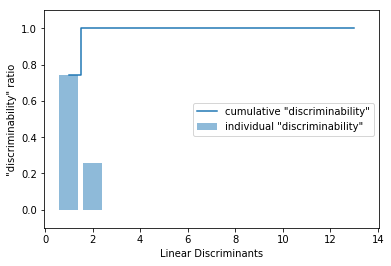

In [40]:
# 내림차순 정렬된 eigen_value 의 선형판별을 시각화
plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1]); plt.legend(loc='best'); plt.show()

In [41]:
# 가장 판별력이 높은 두 개의 eigen_vector 열을 쌓아서, 변환행렬 W를 만든다
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


### 03 sample 을  새로운 feature 공간에 투영하기
변환행렬 W를 활용하여, 훈련데이터를 변환한다

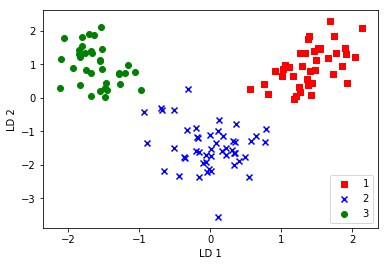

In [42]:
# 새로운 feature의 부분공간에 선형으로 분리
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1'); plt.ylabel('LD 2')
plt.legend(loc='lower right'); plt.show()

### 04 scikit-learn 을 활용한 LDA 구현
LDA Class를 활용한다

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

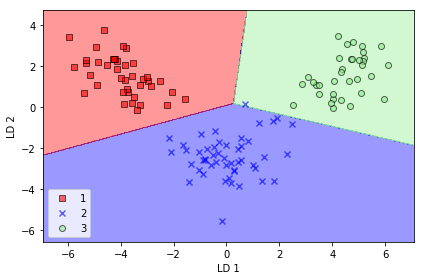

In [45]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

## 3 '비선형 매핑'을 위한 주성분 분석
선형분리 (ADline, Logistic, SVM )는 분류 후 잡음의 문제가 발생 

PCA, LDA의 차원축소도 위와 같은 문제를 내포

대안으로 Kernal SVM, Kernal PCA 를 활용해 새로운 부분공간을 반환

<img src="https://sebastianraschka.com/images/blog/2014/kernel_pca/linear_vs_nonlinear.png" align="left">

### 01 Kernal 함수와 Kernal 트릭
비선형 자료를 '고차원'의 '비선형 매핑'을 수행 후

고차원공간에서 '표준PCA'으로 선형 분류기에 의해 저차원으로 재투영

단점) Kernal Trick 을 사용하여, 계산비용이 비싸지는 단점이 존재

In [46]:
# 계산 process
# 1 Kernal 유사도 행렬 (k) 를 계산한다
# 2 Kernal 행렬 k 에 중심을 둔다
# 3 중심의 Kernal 행렬 에 대한 상위 k개의 eigen_vector를 eigen_value를 기준으로 수집 (내림차순으로 순위화)
# 4 eigen_vector가 주요한 요수축은 아니지만 sample 들은 이 축에 투영된다

### 02 Kernal 주성분 분석
Python 을 활용 (RBF kernel PCA implementation)

In [47]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh
import numpy as np

In [48]:
# 매개변수 (Parameters) ---------
# X: {NumPy ndarray}, shape = [n_samples, n_features]
# gamma: float (Tuning parameter of the RBF kernel)        
# n_components: int (Number of principal components to return)
# 결과값 (Returns) -------------
# X_pc: {NumPy ndarray}, shape = [n_samples, k_features] (Projected dataset)   

In [49]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')    # Calculate pairwise squared Euclidean distances
    mat_sq_dists = squareform(sq_dists)   # Convert pairwise distances into a square matrix.
    K = exp(-gamma * mat_sq_dists)        # Compute the symmetric kernel matrix.
    N = K.shape[0]                        # Center the kernel matrix.
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.linalg.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)    
    X_pc = np.column_stack((eigvecs[:, -i] # Collect the top k eigenvectors (projected samples)
                            for i in range(1, n_components + 1)))

    return X_pc

In [50]:
# scipy, numpy 의 모듈을 활용하면 간단하게 연산이 가능
# 단, gamma 을 사전에 입력해줘야 하는 단점이 존재
# 적절한 gamma 를 찾기 위해서는 그리드 검색'grid search' 을 해야 한다

### 03 사례연구 01
Kernal 주성분 분석으로 '반달모양'으로 분리하기

### 1) 데이터 생성

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# 두개의 반달모양을 나타내는 100개의 샘플점으로 구성된 2차원 데이터를 생성
X, y = make_moons(n_samples=100, random_state=123)

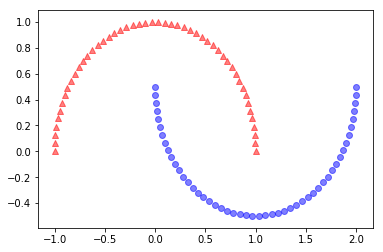

In [52]:
# 생성한 데이터를 시각화
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

### 2) 표준 PCA 주성분 분석결과

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

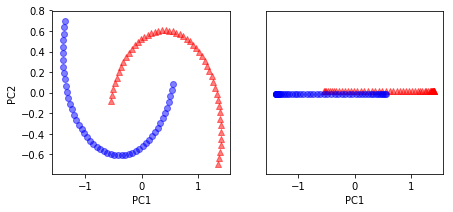

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1]); ax[1].set_yticks([]); ax[1].set_xlabel('PC1')
plt.show()

In [55]:
# 표준PCA 분석결과
# 데이터의 분류결과 중복된 영역이 다수여서 제대로 효과를 나타내지 못한다

### 3) 커널 PCA 함수를 활용한 분석
rbf_kernel_pca(X, gamma, n_components) 를 반달데이터에 적용

In [56]:
# 커널 PCA 분석을 적용 (gamma 값을 15로 임의 지정)
# '모델평가 와 하이퍼 튜닝' 부분을 통한 최적 gammma를 찾는 알고리즘이 설명가능
from matplotlib.ticker import FormatStrFormatter
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
X_kpca[::20]

array([[ 0.0746, -0.1264],
       [ 0.1132,  0.1293],
       [ 0.1318, -0.0706],
       [ 0.1149, -0.1231],
       [ 0.0295, -0.0646]])

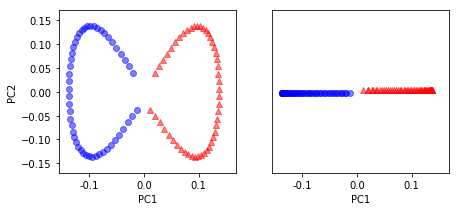

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[1].set_ylim([-1, 1]); ax[1].set_yticks([]); ax[1].set_xlabel('PC1')
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

### 04 사례연구 02
Kernal 주성분 분석으로 '원형모양'으로 분리하기

### 1) 데이터 생성

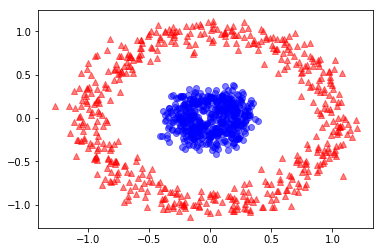

In [58]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

### 2) 표준 PCA 주성분 분석결과

In [59]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

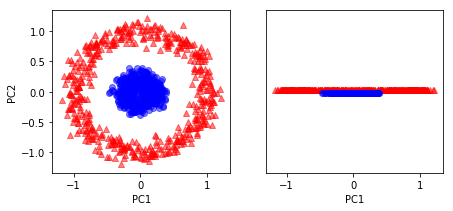

In [60]:
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1]); ax[1].set_yticks([]); ax[1].set_xlabel('PC1')
plt.show()

### 3) 커널 PCA 함수를 활용한 분석
rbf_kernel_pca(X, gamma, n_components) 를 원형데이터에 적용

In [61]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

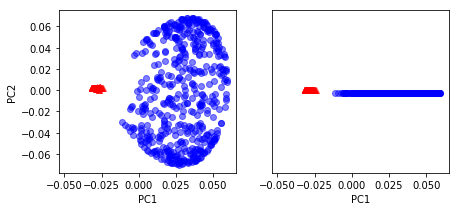

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1');ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1]);ax[1].set_yticks([]); ax[1].set_xlabel('PC1')
plt.show()

### 05 새로운 관측치의 투영
훈련 데이터의 일부가 아닌 관측치를 투영 (RBF kernel PCA implementation)

In [ ]:
# Parameters ------------------------------------------
# X: {NumPy ndarray}, shape = [n_samples, n_features]
# gamma: float (Tuning parameter of the RBF kernel)        
# n_components: int (Number of principal components to return)
# Returns ---------------------------------------------
# X_pc: {NumPy ndarray}, shape = [n_samples, k_features] (Projected dataset)
# lambdas: list (Eigenvalues)

In [63]:
# 표준 PCA : 변환행렬과 입력 샘플간의 '내적'을 통해서 투영
# 투영행렬 : 내적값중 '상위 k개의 eigen_vector'를 공분산 결과 데이터에 투영
# 위 두가지 절차를 Kernal PCA 에 어떻게 전달할 것인가???

In [64]:
# 'Kernal Tick'을 사용하면 투영공식을 계산할 필요가 없다
# 단 훈련데이터 개별 i 샘플 과 새로운 샘플 X 간 'PBF 커널(유사도)'를 계산해야 한다.

In [65]:
# 새로운 샘플과, 훈련 데이터의 '샘플 유사도'를 측정
# 유사도 계산 후, eigen_value로 eigen_vector를 정규화(Normalized) 한다
# 이를 근거로, rbf_kernal_pca로 커널행렬의 eigen_value를 반환한다

In [66]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [67]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')    # in the MxN dimensional dataset.
    mat_sq_dists = squareform(sq_dists)   # Convert pairwise distances into a square matrix.
    K = exp(-gamma * mat_sq_dists)        # Compute the symmetric kernel matrix.
    N = K.shape[0]                        # Center the kernel matrix.
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # kernel matrix 의 중심에 분포한 eigen_pairs를 연산
    eigvals, eigvecs = eigh(K)                # numpy.eigh() 는 행렬을 정렬한 결과를 출력
    alphas = np.column_stack((eigvecs[:, -i]  # eigen_vectors 의 상위 k 값을 정렬
                              for i in range(1, n_components + 1)))
    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]
    return alphas, lambdas

In [68]:
# 반달 데이터를 생성
# 차원을 활용한 RBF Kernal PCA 을 구현
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)
x_new = X[-1]; x_new

array([ 0.4816, -0.3551])

In [69]:
# 원본 데이터를 투영 (original projection)
x_proj = alphas[-1] ; x_proj

array([ 0.1192])

In [70]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas); x_reproj

array([ 0.1192])

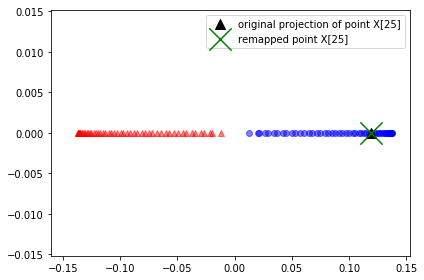

In [71]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1); plt.show()

In [74]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X[:-1, :], gamma=15, n_components=1)

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

In [75]:
# projection of the "new" datapoint
x_new = X[-1]
x_reproj = project_x(x_new, X[:-1], gamma=15, alphas=alphas, lambdas=lambdas)

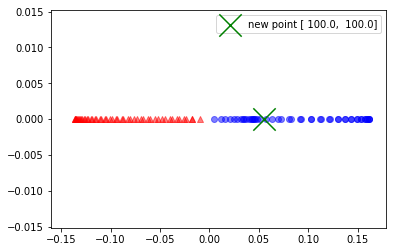

In [76]:
plt.scatter(alphas[y[:-1] == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y[:-1] == 1, 0], np.zeros((49)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_reproj, 0, color='green', label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1); plt.show()

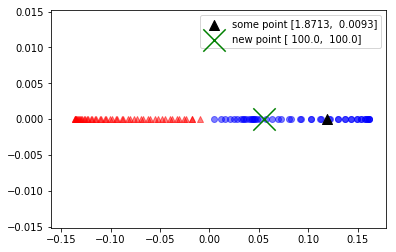

In [77]:
# 첫번쨰 주선분 분석을 투영
plt.scatter(alphas[y[:-1] == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y[:-1] == 1, 0], np.zeros((49)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='some point [1.8713,  0.0093]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='new point [ 100.0,  100.0]', marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()

## 4 scikit-learn 에서  '커널 주성분 분석'
from sklearn.decomposition import KernelPCA

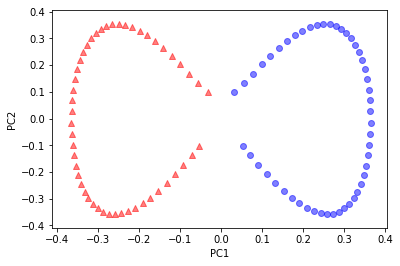

In [78]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

In [ ]:
# 차원축소방법 : 표준PCA(비지도적), LDA (지도적), 커널PCA (비선형 분류들이 선형분류 가능한 저차원으로 매핑)  
# 레이블과 상관없이 '수직 Feature의 축을 따라 분산을 최대화하는 저차원의 부분공간'으로 투영